This notebook analyzes the dataset from https://www.lendingclub.com/
------------------------------------------------------------------------------------------------------





Objectives:
The goal is to analyse the following:

    The target variable
    Variable types (categorical and numerical)
    Missing data

    Numerical variables
        Discrete
        Continuous
        Distributions
        Transformations

    Categorical variables
        Cardinality
        Special Labels

## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Read the data

In [2]:
data = pd.read_csv("https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Lending_Club.csv")

In [3]:
X, y = None, None

In [4]:
data.sample(5)

,Id,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
850,851,0,Department of Homeland Security,4,RENT,64000.0,VERIFIED - income,n,552170 added on 10/07/09 > The purpose of th...,debt consolidation,...,NaN,9.0,0.0,30803,84.4,17.0,f,0.0,2,PC3
6978,6979,0,Fidelity Investments,9,MORTGAGE,84575.0,VERIFIED - income,n,NaN,debt consolidation,...,NaN,12.0,0.0,21188,37.7,41.0,f,0.0,1,PC3
1798,1799,0,S.C.I.,6,RENT,49548.0,VERIFIED - income,n,"Im gonna use the money as emergency money, an...",other,...,NaN,3.0,0.0,3511,40.4,6.0,f,0.0,2,PC2
4279,4280,0,Activated Ministries,4,RENT,52000.0,VERIFIED - income source,n,Borrower added on 11/02/10 > I need to purch...,car,...,NaN,19.0,0.0,3058,3.2,36.0,f,0.0,2,PC2
486,487,0,SUPER FRESH/ A&P TEA CO. INC.,10,MORTGAGE,120000.0,VERIFIED - income,n,I have good credit & have always paid my bills...,other,...,NaN,10.0,0.0,78633,31.7,56.0,f,0.0,1,PC5


In [5]:
data.shape

(10000, 28)

In [6]:
original_features = list(data.columns)
print(original_features)

['Id', 'is_bad', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'Notes', 'purpose_cat', 'purpose', 'zip_code', 'addr_state', 'debt_to_income', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code']


## Explore the target feature

In [7]:
target = data['is_bad']

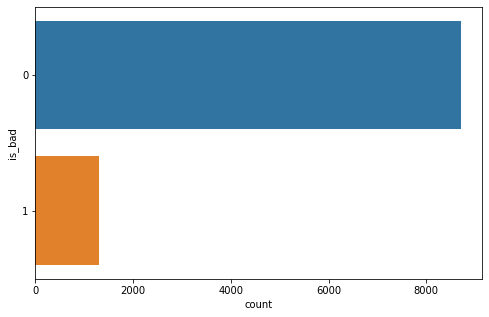

In [8]:
plt.figure(figsize=(8,5));
sns.countplot(y=target);

The dataset is very imbalance. We will process a combination of oversampling or undersampling

## Split Variable types (categorical and numerical)

In [9]:
cat_vars = [var for var in data.columns if(data[var].dtypes == "O")]
print(cat_vars)
print()
print(f"length of categorical variable is {len(cat_vars)}")

['emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'Notes', 'purpose_cat', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'policy_code']

length of categorical variable is 13


In [10]:
num_vars = [var for var in data.columns if(var not in cat_vars)]
print(num_vars)
print()
print(f"lenght of numerical variables is {len(num_vars)}")

['Id', 'is_bad', 'annual_inc', 'debt_to_income', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog']

lenght of numerical variables is 15


## Explore missing data

In [11]:
missing_data = pd.concat([data.isnull().sum().sort_values(ascending=False).rename("missing_counts"), data.isnull().mean().sort_values(ascending=False).rename("missing_percent")], axis=1)

In [12]:
missing_data

,missing_counts,missing_percent
mths_since_last_record,9160,0.9160
mths_since_last_delinq,6316,0.6316
Notes,3167,0.3167
emp_title,592,0.0592
collections_12_mths_ex_med,32,0.0032
revol_util,26,0.0026
earliest_cr_line,5,0.0005
open_acc,5,0.0005
pub_rec,5,0.0005
delinq_2yrs,5,0.0005


We will delete any feature with more than 80% missing values

In [13]:
X = data.drop(columns="is_bad")
y = data["is_bad"]

In [14]:
class TemporalFeaturesExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, variables: str):
        '''
        Extract years ffrom datetime variable
        
        '''
        self.variables = variables
        
        
    def fit(self, X, y=None):
        
        return self
        
    def transform(self, X):
        X = X.copy()
        
        X[self.variables] = pd.DatetimeIndex(X[self.variables]).year
        
        return X

In [15]:
class ExtractZipCode(BaseEstimator, TransformerMixin):
    def __init__(self, variable: str):
        self.variable = variable
        
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        X = X.copy()
        
        X[self.variable] = X[self.variable].str[:3]
        
        return X

In [16]:
class MissingValuesImputerWarpper(SimpleImputer):

    def __init__(self):
        self.columns = X.columns
        
        
    def fit(self, X, y=None):
        
        
        return self
    

    def transform(self, X):
        imputer = SimpleImputer(missing_values = np.nan, strategy ='most_frequent')
        imputer = imputer.fit(X)
 
        X = imputer.transform(X)
        
        X = pd.DataFrame(X, columns=self.columns)
        return X

In [17]:
class ScalerWrapper(MinMaxScaler):
        
    def fit(self, X, y=None):
        self.columns = X.columns.to_list()
        return super().fit(X, y)
    
    
    def transform(self, X):
        X = X.copy()
        
        X = pd.DataFrame(super().transform(X), columns=self.columns)
        
        return X

In [18]:
class OverUnderSAMPLE(SMOTEENN, SMOTETomek, SMOTE):
    def __init__(self):

        self.y = None
    
        
    def fit(self, X, y):
        self.y = y
        
        return self
    
    
    def transform(self, X):
        X = X.copy()
        
        sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=4)
        

        X_sm, y_sm = sm.fit_resample(X, self.y)
        
        
        tl = TomekLinks(sampling_strategy='all', n_jobs=4)

        smtomek = SMOTETomek(sampling_strategy='auto',  random_state=42, smote=sm, tomek=tl, n_jobs=4)

        X, self.y = smtomek.fit_resample(X, self.y)
        
        
        return X, self.y #pd.concat([X, self.y], axis=1, names=list(X.columns + "is_bad"))

In [19]:
feature_eng_pipeline = make_pipeline(
                        MissingValuesImputerWarpper(),
                        TemporalFeaturesExtraction(variables="earliest_cr_line"), 
                        ExtractZipCode(variable="zip_code"),
                        TargetEncoder(True, handle_missing='missing', handle_unknown='missing'),
                        ScalerWrapper(),
                        OverUnderSAMPLE()
                        
                        )

In [20]:
feature_eng_pipeline

Pipeline(steps=[('missingvaluesimputerwarpper', MissingValuesImputerWarpper()),
                ('temporalfeaturesextraction',
                 TemporalFeaturesExtraction(variables='earliest_cr_line')),
                ('extractzipcode', ExtractZipCode(variable='zip_code')),
                ('targetencoder',
                 TargetEncoder(handle_missing='missing',
                               handle_unknown='missing', verbose=True)),
                ('scalerwrapper', ScalerWrapper()),
                ('overundersample', OverUnderSAMPLE())])

In [21]:
X, y = feature_eng_pipeline.fit_transform(X, y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
y

0        0
1        0
2        0
3        0
4        0
        ..
17405    1
17406    1
17407    1
17408    1
17409    1
Name: is_bad, Length: 17410, dtype: int64

In [24]:
# random forests
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=1, random_state=0, n_jobs=4)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[20, 50, 100, 200, 500, 1000],
    max_depth=[2, 3, 4],
)

# search
clf = GridSearchCV(rf_model,
                   rf_param_grid,
                   scoring='roc_auc',
                   cv=5)

search = clf.fit(X_train, y_train)

# best hyperparameters
search.best_params_

{'max_depth': 4, 'n_estimators': 1000}

In [25]:
pred = clf.predict(X_test)

In [26]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 2, 'n_estimators': 20}",0.967782,0.003194
1,"{'max_depth': 2, 'n_estimators': 50}",0.973630,0.003108
2,"{'max_depth': 2, 'n_estimators': 100}",0.975389,0.003021
3,"{'max_depth': 2, 'n_estimators': 200}",0.975530,0.002652
4,"{'max_depth': 2, 'n_estimators': 500}",0.975301,0.002907


Text(0.5, 0, 'Hyperparameter space')

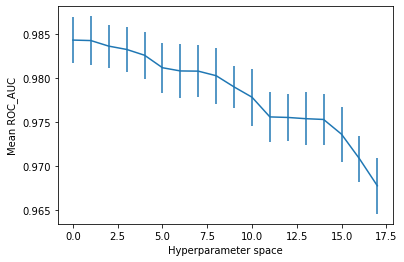

In [27]:


results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean ROC_AUC')
plt.xlabel('Hyperparameter space')
